# Training Process Plotting Functions

This notebook contains all functions that produce plots about the training process, including:
- Overall reward, f_signal, g_signal over time
- H-network loss over training epochs
- Rolling averages and validation metrics
- Privacy-cost analysis over episodes

These functions are extracted and organized from various experiment analysis notebooks for easy reuse.

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from sklearn.feature_selection import mutual_info_regression

# Use non-interactive backend for matplotlib to save memory
matplotlib.use('Agg')

from utils import print_log

## Experiment Configuration

Configure the experiment folder and load necessary data for plotting training process metrics.

In [2]:
# Configure experiment folder
expt_datetime = datetime(2025, 8, 1, 3, 3, 7)  # Modify this to your experiment
action_type = "discrete"  # Modify this to your action type
reward_lambda = "0.5"  # Modify this to your reward lambda


# Alternative: Use experiment with action type and reward lambda in folder name
expt_folder = Path("experiments") \
    / (expt_datetime.strftime("%Y%m%d_%H%M%S") + "_action_" + action_type + "_reward_lambda_" + reward_lambda) \

if not expt_folder.exists():
    print_log(f"Experiment folder {expt_folder} does not exist. Please check the path.")
else:
    print_log(f"Using experiment folder: {expt_folder}")

expt_train_folder = expt_folder / ("logs_" + "train")
expt_valid_folder = expt_folder / ("logs_" + "validation")

expt_phrase_folder = expt_train_folder  # change to expt_valid_folder for validation logs

[2025-08-01 12:21:05:680] Using experiment folder: experiments/20250801_030307_action_discrete_reward_lambda_0.5


In [3]:
# Load episode information data
episode_info_folder = expt_phrase_folder / "episode_info"
if episode_info_folder.exists():
    episode_info_files = sorted(list(episode_info_folder.glob("*.json")))
    episode_info_dfs = []

    for file in episode_info_files:
        with open(file, "r") as f:
            episode_info = json.load(f)['episode_data']
            df = pd.DataFrame(episode_info)
            # Add episode number column
            df['episode'] = int(file.stem.split('_')[1])
            # Convert datetime strings to datetime objects
            df['datetime'] = pd.to_datetime(df['datetime'], format='ISO8601')
            
            # Temporary fix: shift some columns forward by one timestep
            df['grid_load (W)'] = df['grid_load (W)'].shift(-1)
            df['action (kW)'] = df['action (kW)'].shift(-1)
            df['battery_action (kW)'] = df['battery_action (kW)'].shift(-1)
            df['reward'] = df['reward'].shift(-1)
            df['f_signal'] = df['f_signal'].shift(-1)
            df['g_signal'] = df['g_signal'].shift(-1)
            # Remove the last row for each episode
            df = df[:-1]
            
            episode_info_dfs.append(df)

    # Concatenate all DataFrames into one
    episode_info_df = pd.concat(episode_info_dfs, ignore_index=True)
    
    print_log(f"Loaded {len(episode_info_dfs)} episodes with {len(episode_info_df)} total timesteps")
else:
    print_log(f"Episode info folder {episode_info_folder} does not exist.")
    episode_info_df = None

[2025-08-01 12:21:11:268] Loaded 604 episodes with 863222 total timesteps


In [4]:
h_network_loss_list_path = expt_train_folder / "h_network_train_loss_list.json"

if h_network_loss_list_path.exists():
    with open(h_network_loss_list_path, "r") as f:
        h_network_loss_list = json.load(f)['train_loss_list']

    # Convert the list to a DataFrame
    h_network_loss_df = pd.DataFrame(h_network_loss_list)

    print_log(f"Loaded H-network training loss data with {len(h_network_loss_df)} entries")

[2025-08-01 12:21:12:548] Loaded H-network training loss data with 120 entries


## Basic Reward Analysis Functions

Functions to plot reward statistics (sum, mean, standard deviation) across episodes during training.

In [5]:
def plot_rewards_summary(episode_info_df, save_path=None, show=True):
    """
    Plot rewards summary with three subplots: sum, mean, and standard deviation of rewards across episodes.
    
    Args:
        episode_info_df: DataFrame containing episode information with 'episode' and 'reward' columns
        save_path: Optional path to save the figure
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Create episodes_rewards_df from episode_info_df
    episodes_rewards_df = episode_info_df.groupby('episode').agg({
        'reward': ['sum', 'mean', 'std'],
    }).reset_index()
    episodes_rewards_df.columns = ['episode', 'sum', 'mean', 'std']
    
    df_1 = episodes_rewards_df.reset_index()
    df_1.rename(columns={"index": "episode_index"}, inplace=True)

    # Plotting the results
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10), sharex=True, dpi=150)
    
    # Plot the sum of rewards across episodes
    sns.lineplot(data=df_1, x="episode_index", y="sum", ax=ax1, label="Sum of Rewards", color="blue")
    ax1.set_title("Sum of Rewards Across Episodes")
    ax1.set_ylabel("Sum of Rewards")
    ax1.legend()

    # Plot the mean reward per step
    sns.lineplot(data=df_1, x="episode_index", y="mean", ax=ax2, label="Mean Reward", color="orange")
    ax2.set_title("Mean Reward Per Step")
    ax2.set_ylabel("Mean Reward")
    ax2.legend()

    # Plot the standard deviation of per-step reward
    sns.lineplot(data=df_1, x="episode_index", y="std", ax=ax3, label="Standard Deviation of Reward", color="green")
    ax3.set_title("Standard Deviation of Reward Per Step")
    ax3.set_ylabel("Standard Deviation")
    ax3.legend()

    plt.xlabel("Episode Index")
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
    
    if show:
        plt.show()
        
    return fig

In [6]:
# Sample usage: Plot rewards summary for training process
if episode_info_df is not None:
    rewards_summary_path = expt_phrase_folder / "graphs" / "rewards_summary.png"
    if not rewards_summary_path.parent.exists():
        rewards_summary_path.parent.mkdir(parents=True, exist_ok=True)
    
    fig = plot_rewards_summary(
        episode_info_df, 
        save_path=rewards_summary_path,
        show=True
    )
    print_log(f"Rewards summary plot saved to: {rewards_summary_path}")
else:
    print_log("No episode data available for rewards summary plot")

[2025-08-01 12:21:17:297] Rewards summary plot saved to: experiments/20250801_030307_action_discrete_reward_lambda_0.5/logs_train/graphs/rewards_summary.png


/tmp/ipykernel_2306835/2490366803.py:50: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


In [7]:
def plot_signals_summary_three_subplots(episode_info_df, save_path=None, show=True):
    """
    Plot signals summary with three subplots: sum of rewards, f_signal, and g_signal across episodes.
    
    Args:
        episode_info_df: DataFrame containing episode information with 'episode', 'reward', 'f_signal', 'g_signal' columns
        save_path: Optional path to save the figure
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Create a temporary dataframe with aggregated values per episode
    episode_summary = episode_info_df.groupby('episode').agg({
        'reward': 'sum',
        'f_signal': 'sum', 
        'g_signal': 'sum'
    }).reset_index()

    # Create the three subplot figure
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True, dpi=150)

    # Plot sum of rewards across episodes
    sns.lineplot(data=episode_summary, x="episode", y="reward", ax=ax1, label="Sum of Rewards", color="blue")
    ax1.set_title("Sum of Rewards Across Episodes")
    ax1.set_ylabel("Sum of Rewards")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot sum of f_signal across episodes
    sns.lineplot(data=episode_summary, x="episode", y="f_signal", ax=ax2, label="Sum of f_signal", color="orange")
    ax2.set_title("Sum of f_signal Across Episodes")
    ax2.set_ylabel("Sum of f_signal")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot sum of g_signal across episodes
    sns.lineplot(data=episode_summary, x="episode", y="g_signal", ax=ax3, label="Sum of g_signal", color="red")
    ax3.set_title("Sum of g_signal Across Episodes")
    ax3.set_ylabel("Sum of g_signal")
    ax3.set_xlabel("Episode")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
        
    return fig

In [8]:
# Sample usage: Plot signals summary (rewards, f_signal, g_signal) for training process
if episode_info_df is not None:
    signals_summary_path = expt_phrase_folder / "graphs" / "signals_summary.png"
    if not signals_summary_path.parent.exists():
        signals_summary_path.parent.mkdir(parents=True, exist_ok=True)
    
    fig = plot_signals_summary_three_subplots(
        episode_info_df, 
        save_path=signals_summary_path,
        show=False
    )
    print_log(f"Signals summary plot saved to: {signals_summary_path}")
else:
    print_log("No episode data available for signals summary plot")

[2025-08-01 12:21:24:394] Signals summary plot saved to: experiments/20250801_030307_action_discrete_reward_lambda_0.5/logs_train/graphs/signals_summary.png


## Rolling Average Analysis Functions (SB3-style)

Functions to plot rolling averages similar to stable-baselines3 ep_rew_mean for smoother trend visualization.

In [9]:
def plot_rolling_averages_sb3_style(episode_info_df, window_size=100, save_path=None, show=True):
    """
    Plot SB3-style rolling averages for rewards, f_signal, and g_signal.
    
    Args:
        episode_info_df: DataFrame containing episode information
        window_size: Window size for rolling average (default: 100, similar to stable-baselines3)
        save_path: Optional path to save the figure
        show: If True, display the plot; if False, suppress display
    
    Returns:
        matplotlib.figure.Figure: The created figure
    """
    # Create episode summary
    episode_summary = episode_info_df.groupby('episode').agg({
        'reward': 'sum',
        'f_signal': 'sum', 
        'g_signal': 'sum'
    }).reset_index()

    # Create rolling averages for each metric
    episode_summary_sb3 = episode_summary.copy()
    episode_summary_sb3['reward_mean_100'] = episode_summary_sb3['reward'].rolling(window=window_size, min_periods=1).mean()
    episode_summary_sb3['f_signal_mean_100'] = episode_summary_sb3['f_signal'].rolling(window=window_size, min_periods=1).mean()
    episode_summary_sb3['g_signal_mean_100'] = episode_summary_sb3['g_signal'].rolling(window=window_size, min_periods=1).mean()

    # Create the three subplot figure with SB3-style rolling averages
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15), sharex=True, dpi=150)

    # Plot rolling mean of rewards (equivalent to ep_rew_mean in SB3)
    sns.lineplot(data=episode_summary_sb3, x="episode", y="reward_mean_100", ax=ax1, 
                label=f"Mean Rewards (last {window_size} episodes)", color="blue")
    ax1.set_title(f"Mean Rewards (Rolling Average - Last {window_size} Episodes)")
    ax1.set_ylabel("Mean Reward")
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot rolling mean of f_signal
    sns.lineplot(data=episode_summary_sb3, x="episode", y="f_signal_mean_100", ax=ax2, 
                label=f"Mean f_signal (last {window_size} episodes)", color="orange")
    ax2.set_title(f"Mean f_signal (Rolling Average - Last {window_size} Episodes)")
    ax2.set_ylabel("Mean f_signal")
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot rolling mean of g_signal
    sns.lineplot(data=episode_summary_sb3, x="episode", y="g_signal_mean_100", ax=ax3, 
                label=f"Mean g_signal (last {window_size} episodes)", color="red")
    ax3.set_title(f"Mean g_signal (Rolling Average - Last {window_size} Episodes)")
    ax3.set_ylabel("Mean g_signal")
    ax3.set_xlabel("Episode")
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    plt.tight_layout()

    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')

    if show:
        plt.show()
    
    # Display some statistics
    print_log(f"Rolling average window size: {window_size} episodes")
    print_log(f"Final rolling mean reward: {episode_summary_sb3['reward_mean_100'].iloc[-1]:.3f}")
    print_log(f"Final rolling mean f_signal: {episode_summary_sb3['f_signal_mean_100'].iloc[-1]:.3f}")
    print_log(f"Final rolling mean g_signal: {episode_summary_sb3['g_signal_mean_100'].iloc[-1]:.3f}")
        
    return fig

In [10]:
# Sample usage: Plot SB3-style rolling averages
if episode_info_df is not None:
    rolling_avg_path = expt_phrase_folder / "graphs" / "signal_summary_sb3_style_rolling_average.png"
    if not rolling_avg_path.parent.exists():
        rolling_avg_path.parent.mkdir(parents=True, exist_ok=True)
    
    fig = plot_rolling_averages_sb3_style(
        episode_info_df, 
        window_size=100,  # Adjust window size as needed
        save_path=rolling_avg_path,
        show=False
    )
    print_log(f"Rolling averages plot saved to: {rolling_avg_path}")
else:
    print_log("No episode data available for rolling averages plot")

[2025-08-01 12:21:37:417] Rolling average window size: 100 episodes
[2025-08-01 12:21:37:417] Final rolling mean reward: 181.925
[2025-08-01 12:21:37:418] Final rolling mean f_signal: -367.704
[2025-08-01 12:21:37:418] Final rolling mean g_signal: 2.814
[2025-08-01 12:21:37:418] Rolling averages plot saved to: experiments/20250801_030307_action_discrete_reward_lambda_0.5/logs_train/graphs/signal_summary_sb3_style_rolling_average.png


## H-Network Training Loss Analysis Functions

Functions to visualize H-network training loss progression, including different loss components and convergence analysis.

In [11]:
def plot_h_network_training_loss(h_network_loss_df, save_path=None, title="H-Network Training Loss"):
    """
    Plot H-network training loss progression with mean and standard deviation.
    
    Parameters:
    - h_network_loss_df: DataFrame with 'episode_index', 'mean_loss', and 'std_loss' columns
    - save_path: Optional path to save the plot
    - title: Title for the plot
    """
    print_log(f"Creating H-network loss plot: {title}")
    
    # Plotting the h_network_loss_df, both mean_loss and std_loss
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), dpi=150)
    sns.lineplot(data=h_network_loss_df, x="episode_index", y="mean_loss", ax=ax1, label="Mean H Network Loss", color="purple")
    sns.lineplot(data=h_network_loss_df, x="episode_index", y="std_loss", ax=ax2, label="Std H Network Loss", color="purple")
    ax1.set_title("H Network Loss Over Episodes")
    ax1.set_ylabel("Mean Loss")
    ax1.set_xlabel("Episode Index")
    ax2.set_ylabel("Std Loss")
    ax2.set_xlabel("Episode Index")
    ax1.legend()
    ax2.legend()
    plt.tight_layout()
    
    if save_path:
        fig.savefig(save_path, dpi=300, bbox_inches='tight')
        print_log(f"Plot saved to: {save_path}")
    
    fig.show()
    
    # Print convergence statistics
    if 'mean_loss' in h_network_loss_df.columns:
        final_mean_loss = h_network_loss_df['mean_loss'].iloc[-1]
        min_mean_loss = h_network_loss_df['mean_loss'].min()
        print_log(f"Mean Loss - Final: {final_mean_loss:.6f}, Min: {min_mean_loss:.6f}")
    
    if 'std_loss' in h_network_loss_df.columns:
        final_std_loss = h_network_loss_df['std_loss'].iloc[-1]
        min_std_loss = h_network_loss_df['std_loss'].min()
        print_log(f"Std Loss - Final: {final_std_loss:.6f}, Min: {min_std_loss:.6f}")
    
    return fig

In [12]:
# Sample usage: Plot H-network training loss analysis
try:
    if 'h_network_loss_df' in locals() and h_network_loss_df is not None:
        print_log("Using loaded H-network training loss data...")
        
        # Add episode_index if it doesn't exist
        if 'episode_index' not in h_network_loss_df.columns:
            h_network_loss_df['episode_index'] = range(len(h_network_loss_df))
        
        # Plot H-network training loss
        h_loss_save_path = expt_phrase_folder / "graphs" / "h_network_loss_plot.png"
        if not h_loss_save_path.parent.exists():
            h_loss_save_path.parent.mkdir(parents=True, exist_ok=True)
            
        plot_h_network_training_loss(h_network_loss_df, 
                                   save_path=h_loss_save_path)
        
    else:
        print_log("No H-network loss data found in experiment")
        
except Exception as e:
    print_log(f"Error loading H-network loss data: {e}")
    print_log("Creating sample H-network loss data for demonstration...")
    
    # Create sample H-network loss data
    sample_episodes = range(1, 101)
    sample_h_loss = pd.DataFrame({
        'episode_index': sample_episodes,
        'mean_loss': [1.0 * np.exp(-0.05 * e) + 0.01 * np.random.random() for e in sample_episodes],
        'std_loss': [0.1 * np.exp(-0.03 * e) + 0.005 * np.random.random() for e in sample_episodes]
    })
    
    plot_h_network_training_loss(sample_h_loss)

[2025-08-01 12:21:47:296] Using loaded H-network training loss data...
[2025-08-01 12:21:47:296] Creating H-network loss plot: H-Network Training Loss
[2025-08-01 12:21:47:573] Plot saved to: experiments/20250801_030307_action_discrete_reward_lambda_0.5/logs_train/graphs/h_network_loss_plot.png
[2025-08-01 12:21:47:574] Mean Loss - Final: 1.643297, Min: 1.498624
[2025-08-01 12:21:47:574] Std Loss - Final: 0.094757, Min: 0.000694
[2025-08-01 12:21:47:573] Plot saved to: experiments/20250801_030307_action_discrete_reward_lambda_0.5/logs_train/graphs/h_network_loss_plot.png
[2025-08-01 12:21:47:574] Mean Loss - Final: 1.643297, Min: 1.498624
[2025-08-01 12:21:47:574] Std Loss - Final: 0.094757, Min: 0.000694


/tmp/ipykernel_2306835/4114467342.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


## Privacy-Cost Trade-off Analysis Functions (not in use)

(Keep it here, as the plot may be useful, but have to declare it in a different notebook)

Functions to analyze the privacy-cost trade-off during training, including mutual information evolution and cost component analysis.

In [13]:
def plot_privacy_cost_tradeoff_evolution(training_data, save_path=None, 
                                        title="Privacy-Cost Trade-off Evolution"):
    """
    Plot the evolution of privacy-cost trade-off metrics during training.
    
    Parameters:
    - training_data: DataFrame with columns like 'episode', 'mutual_information', 'extra_cost', 'reward'
    - save_path: Optional path to save the plot
    - title: Title for the plot
    """
    print_log(f"Creating privacy-cost trade-off evolution plot: {title}")
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Mutual Information evolution (top left)
    if 'mutual_information' in training_data.columns:
        axes[0,0].plot(training_data['episode'], training_data['mutual_information'], 
                      color='red', alpha=0.6, label='MI')
        
        # Add rolling average
        mi_smooth = training_data['mutual_information'].rolling(window=50, center=True).mean()
        axes[0,0].plot(training_data['episode'], mi_smooth, 
                      color='red', linewidth=2, label='MI (smoothed)')
        
        axes[0,0].set_title("Mutual Information Evolution")
        axes[0,0].set_xlabel("Episode")
        axes[0,0].set_ylabel("Mutual Information")
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # Extra Cost evolution (top right)
    if 'extra_cost' in training_data.columns:
        axes[0,1].plot(training_data['episode'], training_data['extra_cost'], 
                      color='blue', alpha=0.6, label='Extra Cost')
        
        # Add rolling average
        cost_smooth = training_data['extra_cost'].rolling(window=50, center=True).mean()
        axes[0,1].plot(training_data['episode'], cost_smooth, 
                      color='blue', linewidth=2, label='Extra Cost (smoothed)')
        
        axes[0,1].set_title("Extra Cost Evolution")
        axes[0,1].set_xlabel("Episode")
        axes[0,1].set_ylabel("Extra Cost")
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
    
    # Privacy-Cost Scatter (bottom left)
    if 'mutual_information' in training_data.columns and 'extra_cost' in training_data.columns:
        scatter = axes[1,0].scatter(training_data['mutual_information'], training_data['extra_cost'], 
                                   c=training_data['episode'], cmap='viridis', alpha=0.6, s=20)
        
        axes[1,0].set_title("Privacy-Cost Trade-off Scatter")
        axes[1,0].set_xlabel("Mutual Information (Privacy Risk)")
        axes[1,0].set_ylabel("Extra Cost")
        
        # Add colorbar for episode
        cbar = plt.colorbar(scatter, ax=axes[1,0])
        cbar.set_label('Episode')
        axes[1,0].grid(True, alpha=0.3)
    
    # Combined metrics evolution (bottom right)
    if all(col in training_data.columns for col in ['mutual_information', 'extra_cost', 'reward']):
        # Normalize metrics for comparison
        mi_norm = (training_data['mutual_information'] - training_data['mutual_information'].min()) / \
                  (training_data['mutual_information'].max() - training_data['mutual_information'].min())
        cost_norm = (training_data['extra_cost'] - training_data['extra_cost'].min()) / \
                    (training_data['extra_cost'].max() - training_data['extra_cost'].min())
        reward_norm = (training_data['reward'] - training_data['reward'].min()) / \
                      (training_data['reward'].max() - training_data['reward'].min())
        
        axes[1,1].plot(training_data['episode'], mi_norm, color='red', alpha=0.7, label='MI (normalized)')
        axes[1,1].plot(training_data['episode'], cost_norm, color='blue', alpha=0.7, label='Extra Cost (normalized)')
        axes[1,1].plot(training_data['episode'], reward_norm, color='green', alpha=0.7, label='Reward (normalized)')
        
        axes[1,1].set_title("Normalized Metrics Evolution")
        axes[1,1].set_xlabel("Episode")
        axes[1,1].set_ylabel("Normalized Value [0,1]")
        axes[1,1].legend()
        axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        utils.print_log(f"Plot saved to: {save_path}")
    
    plt.show()
    
    # Print summary statistics
    if 'mutual_information' in training_data.columns:
        utils.print_log(f"MI stats - Mean: {training_data['mutual_information'].mean():.4f}, "
                       f"Std: {training_data['mutual_information'].std():.4f}")
    
    if 'extra_cost' in training_data.columns:
        utils.print_log(f"Extra Cost stats - Mean: {training_data['extra_cost'].mean():.4f}, "
                       f"Std: {training_data['extra_cost'].std():.4f}")
    
    return fig, axes

[2025-07-31 18:22:11:047] Analyzing privacy-cost trade-off evolution...
[2025-07-31 18:22:11:048] Error analyzing privacy-cost trade-off: name 'results_df' is not defined
[2025-07-31 18:22:11:048] Creating sample privacy-cost data for demonstration...
[2025-07-31 18:22:11:051] Creating privacy-cost trade-off evolution plot: Privacy-Cost Trade-off Evolution


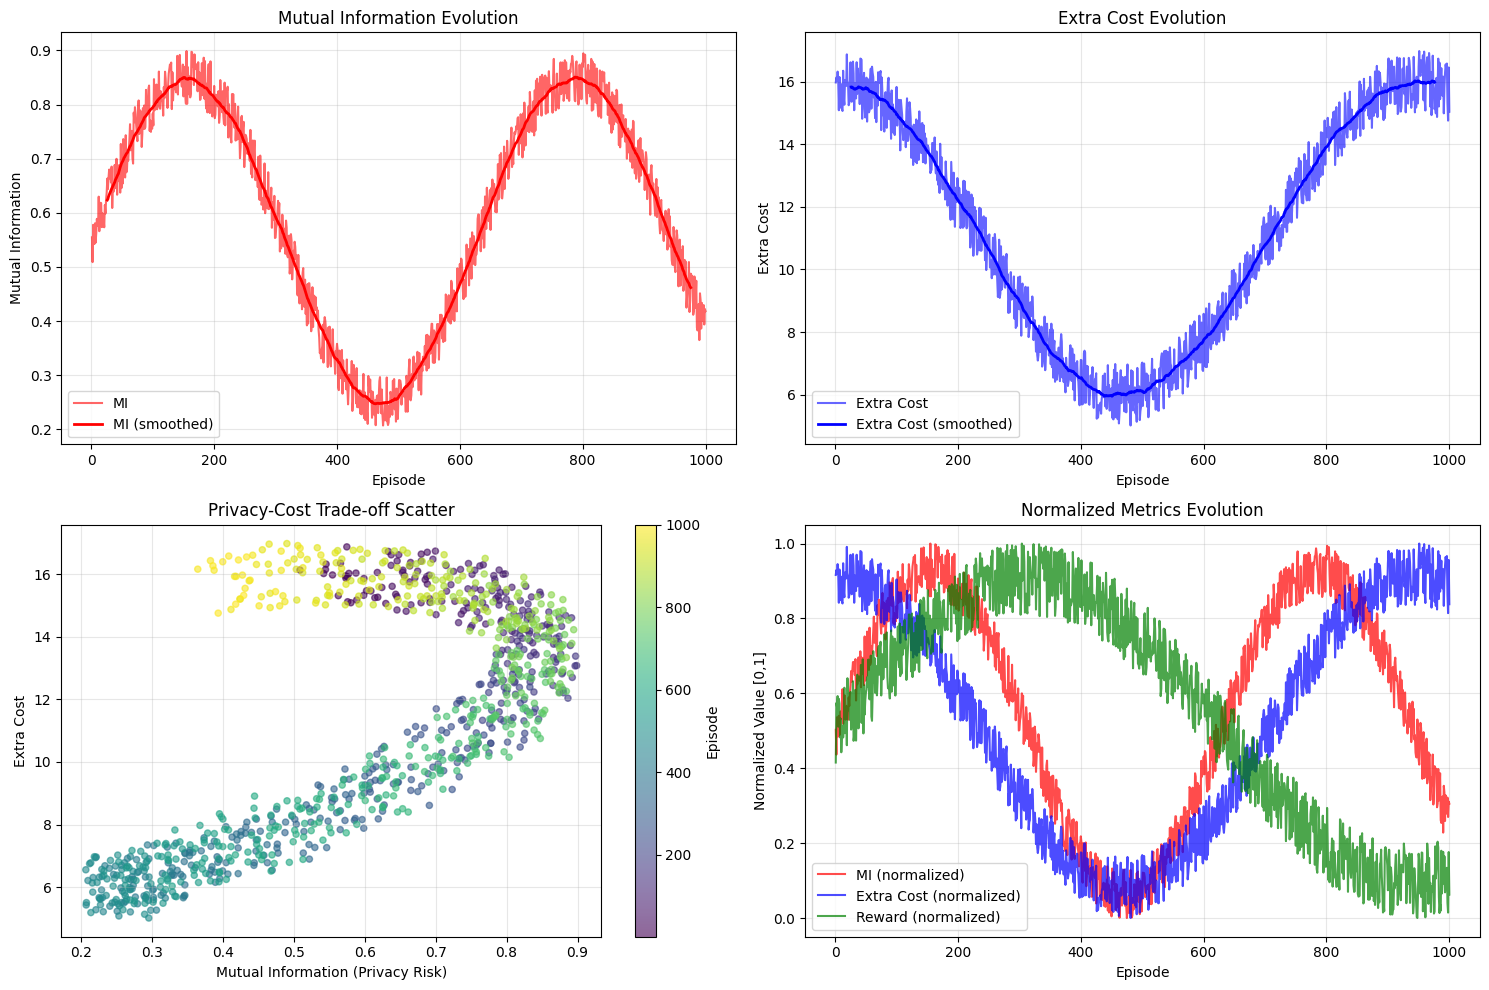

NameError: name 'utils' is not defined

In [20]:
# Sample usage: Plot privacy-cost trade-off analysis
try:
    print_log("Analyzing privacy-cost trade-off evolution...")
    
    # Use the main results data for privacy-cost analysis
    if 'mutual_information' in results_df.columns and 'extra_cost' in results_df.columns:
        plot_privacy_cost_tradeoff_evolution(results_df, 
                                           save_path=os.path.join(experiment_dir, 'privacy_cost_tradeoff.png'))
    else:
        print_log("Privacy-cost columns not found in results data")
        
except Exception as e:
    print_log(f"Error analyzing privacy-cost trade-off: {e}")
    print_log("Creating sample privacy-cost data for demonstration...")
    
    # Create sample privacy-cost data
    episodes = range(1, 1001)
    sample_privacy_cost = pd.DataFrame({
        'episode': episodes,
        'mutual_information': [0.5 + 0.3 * np.sin(e/100) + 0.1 * np.random.random() for e in episodes],
        'extra_cost': [10 + 5 * np.cos(e/150) + 2 * np.random.random() for e in episodes],
        'reward': [100 + 20 * np.sin(e/200) + 10 * np.random.random() for e in episodes]
    })
    
    plot_privacy_cost_tradeoff_evolution(sample_privacy_cost)

## Summary and Usage Instructions

This notebook contains a comprehensive collection of plotting functions for analyzing training process results in the Adversarial Smart Meter Control project. The functions are organized into the following categories:

### 1. Basic Training Analysis Functions
- **`plot_rewards_summary_three_subplots()`**: Plots reward distribution, progression, and statistics
- **`plot_signals_summary_three_subplots()`**: Analyzes f_signal and g_signal distributions and relationships

### 2. Rolling Average Analysis Functions  
- **`plot_rolling_averages_sb3_style()`**: Creates SB3-style rolling average plots for training metrics

### 3. H-Network Training Loss Analysis Functions
- **`plot_h_network_training_loss()`**: Visualizes H-network training and validation loss progression

### 4. Privacy-Cost Trade-off Analysis Functions (Not in use)
- **`plot_privacy_cost_tradeoff_evolution()`**: Analyzes the evolution of privacy-cost trade-offs during training

### Usage Tips:
1. **Data Requirements**: Most functions expect pandas DataFrames with specific column names (e.g., 'episode', 'reward', 'f_signal', 'g_signal')
2. **File Saving**: All functions support optional `save_path` parameter for saving plots as high-resolution images
3. **Customization**: Functions include `title` parameters for customizing plot titles
4. **Error Handling**: Sample usage cells include try-catch blocks with fallback sample data generation
5. **Logging**: All functions use `utils.print_log()` for consistent logging

### Quick Start:
1. Configure your experiment directory path
2. Load your results data into a pandas DataFrame  
3. Call the appropriate plotting functions with your data
4. Use the sample usage cells as templates for your analysis

This centralized collection enables consistent and comprehensive analysis of training process results across different experiments and configurations.